# Semantic Segmentation

- Élèves :
  - Matías DUHALDE
  - Matthieu MASSARDIER

## Dependencies

In [81]:
%pip install torch matplotlib pandas numpy Pillow scikit-learn
TRAIN = True

Note: you may need to restart the kernel to use updated packages.


In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from os import path
from PIL import Image
from sklearn.model_selection import train_test_split


## Dataset

### Path

In [83]:
DATASET_PATH = 'dataset'
TRAIN_CSV_PATH = path.join(DATASET_PATH, 'train.csv')
DEPTHS_CSV_PATH = path.join(DATASET_PATH, 'depths.csv')
SAMPLE_SUBMISSION_CSV_PATH = path.join(DATASET_PATH, 'sample_submission.csv')

TRAIN_DATASET_PATH = path.join(DATASET_PATH, 'train')
TRAIN_MASK_IMAGES_PATH = path.join(TRAIN_DATASET_PATH, 'masks')
TRAIN_IMAGES_PATH = path.join(TRAIN_DATASET_PATH, 'images')
IMAGE_EXT = '.png'

### Train import

In [84]:
dataset = pd.read_csv(TRAIN_CSV_PATH)


print(f"Element count: {len(dataset)}")
dataset.head()


Element count: 4000


,id,rle_mask
0,2c45b152f1,99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...
1,3cb59a4fdc,1 5656
2,e185ab5dc1,4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...
3,c78c89577c,101 1
4,6306dd3a8e,1 30 102 29 203 29 304 28 405 27 506 27 607 26...


In [85]:
# We only care about the ids
dataset_ids = np.array(dataset['id'])


### Functions

In [86]:
def load_image(image_id, image_type='images'):
    image_file = image_id + IMAGE_EXT
    image_path = path.join(TRAIN_DATASET_PATH, image_type, image_file)
    # Use only a single channel
    image = Image.open(image_path).convert('L')
    # Uscale image to 128x128
    image = image.resize((128, 128), Image.Resampling.LANCZOS)
    return np.array(image)


### Image visualization

Image shape: (128, 128)
Mask shape: (128, 128)


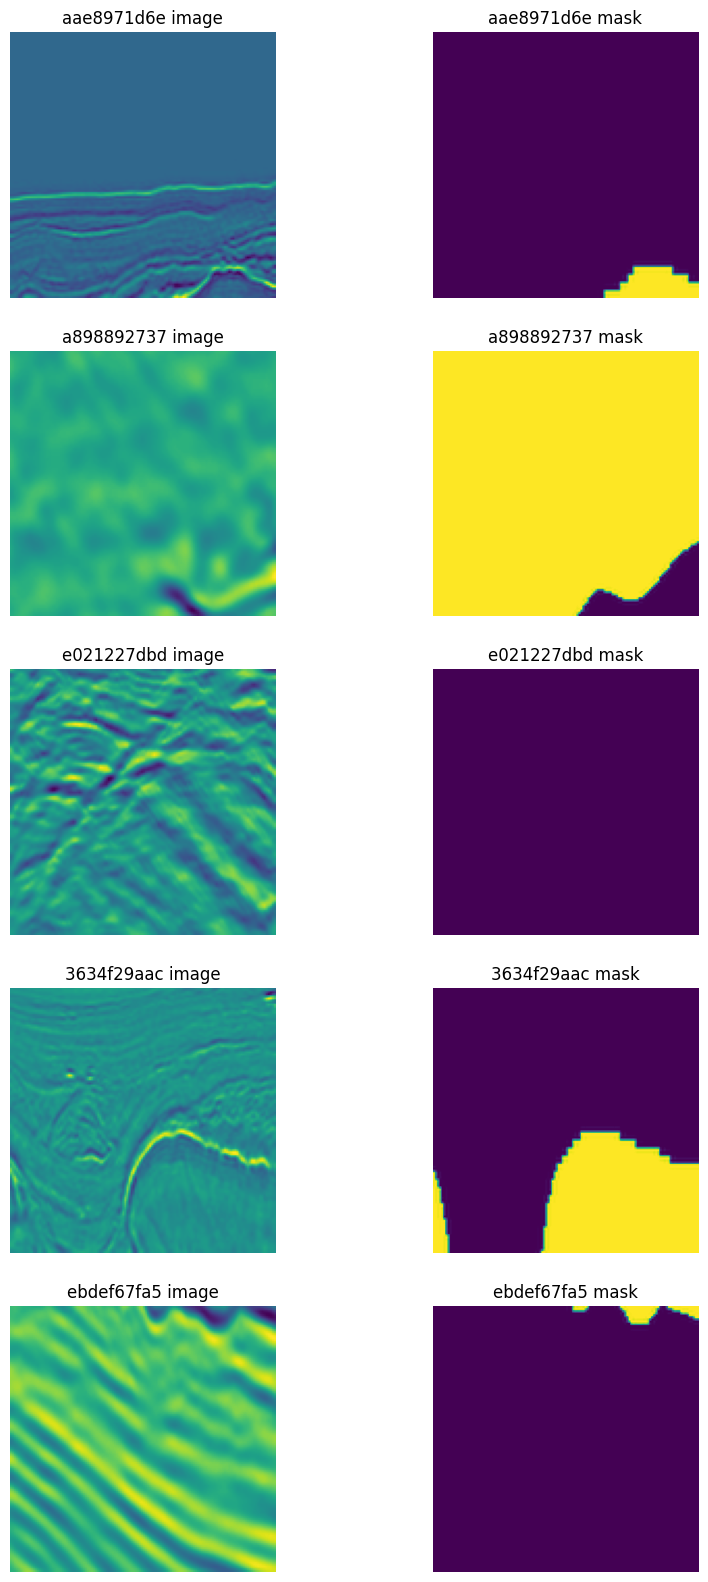

[[174 175 175 ...  77  89  97]
 [173 174 175 ...  52  66  77]
 [172 173 174 ...  20  34  46]
 ...
 [168 176 187 ... 242 237 233]
 [163 168 176 ... 243 240 239]
 [162 164 167 ... 239 239 238]]


In [87]:
# show image
idx = [5, 10 , 15, 20, 25]

fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i, ax in enumerate(axes):
    entry_id = dataset_ids[idx[i]]
    image_path = path.join(TRAIN_IMAGES_PATH, entry_id + IMAGE_EXT)
    mask_path = path.join(TRAIN_MASK_IMAGES_PATH, entry_id + IMAGE_EXT)
    img = load_image(entry_id, 'images')
    mask = load_image(entry_id, 'masks')
    ax[0].imshow(img)
    ax[1].imshow(mask)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].set_title(entry_id + ' image')
    ax[1].set_title(entry_id + ' mask')

print(f'Image shape: {img.shape}')
print(f'Mask shape: {mask.shape}')

plt.show()

print(img)


Remarks:

- Original images are of size (101, 101). We resize them to (128, 128) to adapt them to our network.
- Images have 4 color channels, where the last one is the alpha channel and always equal to 1.
- The rest of the channels are the RGB channels. Since the images are in grayscale, the 3 channels are equal to each other.
- Masks only have a single channel.

## Model

In [88]:
class UNet(nn.Module):
    def __init__(self, debug=False):
        super(UNet, self).__init__()
        self.debug = debug

        self.encoder_path()

        self.decoder_path()

    def encoder_path(self):
        # First double convolutional layer
        # Input size = 1x128x128
        # Output size = 16x128x128
        self.c1 = self.double_conv_layer(1, 16)

        # Max pooling layer
        # Input size = 16x128x128
        # Output size = 16x64x64
        # Stride = 2
        # Filter size = 2x2
        self.p1 = nn.MaxPool2d(2, 2)

        # Second double convolutional layer
        # Input size = 16x64x64
        # Output size = 32x64x64
        self.c2 = self.double_conv_layer(16, 32)

        # Max pooling layer
        # Input size = 32x64x64
        # Output size = 32x32x32
        # Stride = 2
        # Filter size = 2x2
        self.p2 = nn.MaxPool2d(2, 2)

        # Third double convolutional layer
        # Input size = 32x32x32
        # Output size = 64x32x32
        self.c3 = self.double_conv_layer(32, 64)

        # Max pooling layer
        # Input size = 64x32x32
        # Output size = 64x16x16
        # Stride = 2
        # Filter size = 2x2
        self.p3 = nn.MaxPool2d(2, 2)

        # Fourth double convolutional layer
        # Input size = 64x16x16
        # Output size = 128x16x16
        self.c4 = self.double_conv_layer(64, 128)

        # Max pooling layer
        # Input size = 128x16x16
        # Output size = 128x8x8
        # Stride = 2
        # Filter size = 2x2
        self.p4 = nn.MaxPool2d(2, 2)

        # Fifth double convolutional layer
        # Input size = 128x8x8
        # Output size = 256x8x8
        self.c5 = self.double_conv_layer(128, 256)

    def decoder_path(self):
        # First upsampling layer (transposed convolution)
        # Input size = 256x8x8
        # Output size = 128x16x16
        self.u6 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        
        # Sixth double convolutional layer
        # Input size = 256x16x16
        # Output size = 128x16x16
        self.c6 = self.double_conv_layer(256, 128)

        # Second upsampling layer (transposed convolution)
        # Input size = 128x16x16
        # Output size = 64x32x32
        self.u7 = nn.ConvTranspose2d(128, 64, 2, stride=2)

        # Seventh double convolutional layer
        # Input size = 128x32x32
        # Output size = 64x32x32
        self.c7 = self.double_conv_layer(128, 64)

        # Third upsampling layer (transposed convolution)
        # Input size = 64x32x32
        # Output size = 32x64x64
        self.u8 = nn.ConvTranspose2d(64, 32, 2, stride=2)

        # Eighth double convolutional layer
        # Input size = 64x64x64
        # Output size = 32x64x64
        self.c8 = self.double_conv_layer(64, 32)

        # Fourth upsampling layer (transposed convolution)
        # Input size = 32x64x64
        # Output size = 16x128x128
        self.u9 = nn.ConvTranspose2d(32, 16, 2, stride=2)

        # Ninth double convolutional layer
        # Input size = 32x128x128
        # Output size = 16x128x128
        self.c9 = self.double_conv_layer(32, 16)

        # Output layer
        # Input size = 16x128x128
        # Output size = 1x128x128
        self.output = nn.Sequential(
            nn.Conv2d(16, 1, 1),
            # Sigmoid is useful because it's centered around 0.5
            nn.Sigmoid()
        )



    def double_conv_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        batch_size = x.size(0)
        if self.debug:
            assert x.size() == (batch_size, 1, 128, 128)

        # ============
        # Encoder path
        # ============

        c1 = self.c1(x)
        # Size: (batch_size, 16, 128, 128)
        if self.debug:
            assert c1.size() == (batch_size, 16, 128, 128)
        p1 = self.p1(c1)
        # Size: (batch_size, 16, 64, 64)
        if self.debug:
            assert p1.size() == (batch_size, 16, 64, 64)
        c2 = self.c2(p1)
        # Size: (batch_size, 32, 64, 64)
        if self.debug:
            assert c2.size() == (batch_size, 32, 64, 64)
        p2 = self.p2(c2)
        # Size: (batch_size, 32, 32, 32)
        if self.debug:
            assert p2.size() == (batch_size, 32, 32, 32)
        c3 = self.c3(p2)
        # Size: (batch_size, 64, 32, 32)
        if self.debug:
            assert c3.size() == (batch_size, 64, 32, 32)
        p3 = self.p3(c3)
        # Size: (batch_size, 64, 16, 16)
        if self.debug:
            assert p3.size() == (batch_size, 64, 16, 16)
        c4 = self.c4(p3)
        # Size: (batch_size, 128, 16, 16)
        if self.debug:
            assert c4.size() == (batch_size, 128, 16, 16)
        p4 = self.p4(c4)
        # Size: (batch_size, 128, 8, 8)
        if self.debug:
            assert p4.size() == (batch_size, 128, 8, 8)
        c5 = self.c5(p4)
        # Size: (batch_size, 256, 8, 8)
        if self.debug:
            assert c5.size() == (batch_size, 256, 8, 8)

        # ============
        # Decoder path
        # ============

        u6 = self.u6(c5)
        # Size: (batch_size, 128, 16, 16)
        if self.debug:
            assert u6.size() == (batch_size, 128, 16, 16)

        # Skip connection
        u6 = torch.cat([u6, c4], 1)
        # Size: (batch_size, 256, 16, 16)
        if self.debug:
            assert u6.size() == (batch_size, 256, 16, 16)

        c6 = self.c6(u6)
        # Size: (batch_size, 128, 16, 16)
        if self.debug:
            assert c6.size() == (batch_size, 128, 16, 16)
        
        u7 = self.u7(c6)
        # Size: (batch_size, 64, 32, 32)
        if self.debug:
            assert u7.size() == (batch_size, 64, 32, 32)

        # Skip connection
        u7 = torch.cat([u7, c3], 1)
        # Size: (batch_size, 128, 32, 32)
        if self.debug:
            assert u7.size() == (batch_size, 128, 32, 32)

        c7 = self.c7(u7)
        # Size: (batch_size, 64, 32, 32)
        if self.debug:
            assert c7.size() == (batch_size, 64, 32, 32)

        u8 = self.u8(c7)
        # Size: (batch_size, 32, 64, 64)
        if self.debug:
            assert u8.size() == (batch_size, 32, 64, 64)

        # Skip connection
        u8 = torch.cat([u8, c2], 1)
        # Size: (batch_size, 64, 64, 64)
        if self.debug:
            assert u8.size() == (batch_size, 64, 64, 64)

        c8 = self.c8(u8)
        # Size: (batch_size, 32, 64, 64)
        if self.debug:
            assert c8.size() == (batch_size, 32, 64, 64)

        u9 = self.u9(c8)
        # Size: (batch_size, 16, 128, 128)
        if self.debug:
            assert u9.size() == (batch_size, 16, 128, 128)

        # Skip connection
        u9 = torch.cat([u9, c1], 1)
        # Size: (batch_size, 32, 128, 128)
        if self.debug:
            assert u9.size() == (batch_size, 32, 128, 128)

        c9 = self.c9(u9)
        # Size: (batch_size, 16, 128, 128)
        if self.debug:
            assert c9.size() == (batch_size, 16, 128, 128)

        output = self.output(c9)
        # Size: (batch_size, 1, 128, 128)
        if self.debug:
            assert output.size() == (batch_size, 1, 128, 128)

        return output


## Training

In [89]:
def load_batch(ids):
    return {
        'images': load_batch_images(ids),
        'masks': load_batch_masks(ids)
    }

def load_batch_images(ids):
    images = []
    for i in ids:
        image = load_image(i, 'images')
        images.append(image)
    return np.array(images)

def load_batch_masks(ids):
    images = []
    for i in ids:
        image = load_image(i, 'masks')
        image = image // 255
        images.append(image)
    return np.array(images)

In [107]:
def train(model, train_data, validation_data, epochs=32, batch_size=32, learning_rate=0.0001, model_path='model.pth'):
    # Model is compiled with Adam optimizer
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Reduce learning rate on plateau
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1)

    # We use Binary Cross Entropy loss function since there are only two classes
    criterion = nn.BCELoss()

    training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

    # We start with an infinite loss
    min_loss = float('inf')
    stagnation = 0

    for epoch in range(epochs):
        print('Epoch', epoch + 1)
        epoch_loss = 0
        for i, batch_ids in enumerate(training_loader):
            # Retrieve batch
            batch = load_batch(batch_ids)
            inputs = torch.tensor(batch['images'], dtype=torch.float32).to('cuda')
            labels = torch.tensor(batch['masks'], dtype=torch.float32).to('cuda')

            inputs = inputs.unsqueeze(1)
            labels = labels.unsqueeze(1)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() / (len(train_data) / batch_size)
        
        print('Epoch', epoch + 1, 'Training Loss:', epoch_loss)

        # validation loss
        with torch.no_grad():
            val_loss = 0
            for i, batch_ids in enumerate(validation_loader):
                batch = load_batch(batch_ids)
                inputs = torch.tensor(batch['images'], dtype=torch.float32).to('cuda')
                labels = torch.tensor(batch['masks'], dtype=torch.float32).to('cuda')

                inputs = inputs.unsqueeze(1)
                labels = labels.unsqueeze(1)

                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() / (len(validation_data) / batch_size)
        print('Epoch', epoch + 1, 'Validation Loss:', val_loss)

        # If improvement in validation loss, save model
        if val_loss < min_loss:
            # Better validation loss, save model
            min_loss = val_loss
            torch.save(model.state_dict(), model_path)
            stagnation = 0
        else:
            stagnation += 1
            print ('Validation loss did not improve in epoch', epoch + 1)
            if stagnation > 9:
                print('Stagnating for too long, early stopping')
                break
            elif stagnation > 4:
                print('Stagnating for too long, learning rate decay')
                scheduler.step(val_loss)



In [91]:
train_size = 0.8

train_data, val_data = train_test_split(dataset_ids, train_size=train_size)


In [174]:
model = UNet().to('cuda')

train(model, train_data, val_data, epochs=128)

Epoch 1
Epoch 1 Training Loss: 0.53765496969223
Epoch 1 Validation Loss: 0.4673950469493866
Epoch 2
Epoch 2 Training Loss: 0.439128734767437
Epoch 2 Validation Loss: 0.41384526491165163
Epoch 3
Epoch 3 Training Loss: 0.4022194761037826
Epoch 3 Validation Loss: 0.3888385701179505
Epoch 4
Epoch 4 Training Loss: 0.37386498183011996
Epoch 4 Validation Loss: 0.36996479272842403
Epoch 5
Epoch 5 Training Loss: 0.3499680763483047
Epoch 5 Validation Loss: 0.34947140455245973
Epoch 6
Epoch 6 Training Loss: 0.3275585597753524
Epoch 6 Validation Loss: 0.32174678921699523
Epoch 7
Epoch 7 Training Loss: 0.31285575717687625
Epoch 7 Validation Loss: 0.3122015953063966
Epoch 8
Epoch 8 Training Loss: 0.29000336483120903
Epoch 8 Validation Loss: 0.30932788848876963
Epoch 9
Epoch 9 Training Loss: 0.27502716898918145
Epoch 9 Validation Loss: 0.28211359918117523
Epoch 10
Epoch 10 Training Loss: 0.2575370240211487
Epoch 10 Validation Loss: 0.2748746240139007
Epoch 11
Epoch 11 Training Loss: 0.241950973421335

KeyboardInterrupt: 

In [93]:
def predict(model, ids):
    model.eval()

    batch = load_batch(ids)
    inputs = torch.tensor(batch['images'], dtype=torch.float32).to('cuda')
    inputs = inputs.unsqueeze(1)

    with torch.no_grad():
        outputs = model(inputs)
        outputs = outputs.cpu().numpy()
        outputs = np.squeeze(outputs, axis=1)

        outputs = (outputs > 0.5).astype(np.uint8)
        return outputs

In [97]:
def plot_predictions(ids, predictions):
    n = len(ids)
    fig, axes = plt.subplots(n, 3, figsize=(10, 10))

    for i, ax in enumerate(axes):
        entry_id = ids[i]
        img = load_image(entry_id, 'images')
        mask = load_image(entry_id, 'masks')
        pred = predictions[i]
        ax[0].imshow(img)
        ax[1].imshow(pred)
        ax[2].imshow(mask)
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        ax[0].set_title(entry_id + ' image')
        ax[1].set_title(entry_id + ' prediction')
        ax[2].set_title(entry_id + ' real')


    plt.show()


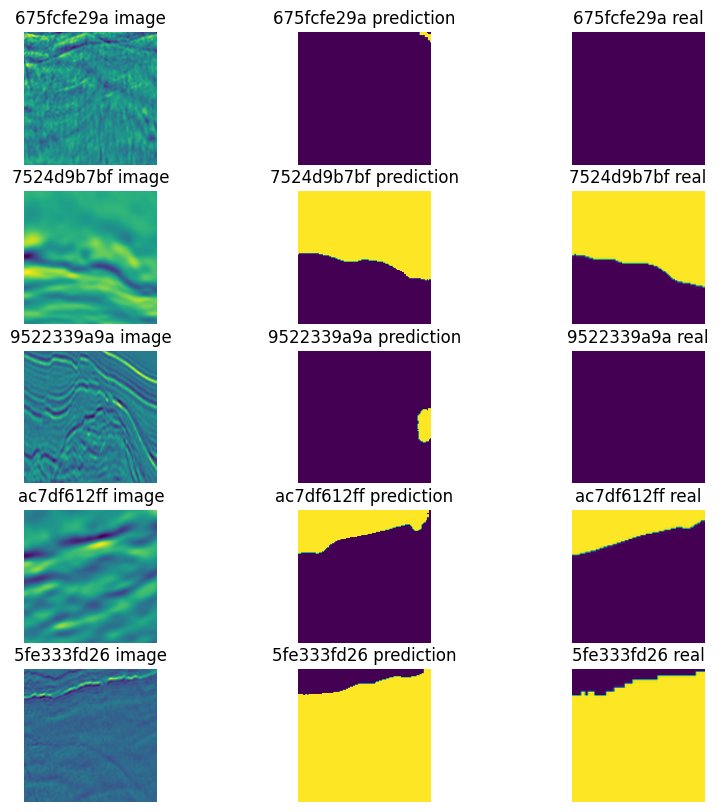

In [166]:
from random import sample

# load from model.pth
model = UNet().to('cuda')
model.load_state_dict(torch.load('model.pth'))

ids = np.array(sample(list(dataset_ids), 5))

predictions = predict(model, ids)

plot_predictions(ids, predictions)

## Questions

### 5.1 Max Pooling

Max pooling has been used for down-sizing the input volume. Instead of max pooling, is it possible to simply make use of convolution with a different stride, e.g., 2 ? How does it impact the performance ?


**Response** : Yes, it is possible to separate the double convolution layers in two, and apply a stride of two to the second part of each, while saving the first value for later use in the decoding part. This way, we can create tensors of compatible dimensions at each layer, while eliminating completely the max pooling layers, as shown below.

The training time does not seem to be affected significantly by this change. However, the performance of the model is notably worse when compared to the one including max pooling. The validation loss after training also ends up being higher. We can also verify the performance difference by comparing the predicted masks with the ground truth masks as shown below.

In [149]:
class UNet2(nn.Module):
    def __init__(self, debug=False):
        super(UNet2, self).__init__()
        self.debug = debug

        self.encoder_path()

        self.decoder_path()

    def encoder_path(self):
        self.c1 =nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
        )
        self.c1a = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.c2a = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.c3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.c3a = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.c4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.c4a = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.c5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )


    def decoder_path(self):
        self.u6 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        
        self.c6 = self.double_conv_layer(256, 128)

        self.u7 = nn.ConvTranspose2d(128, 64, 2, stride=2)

        self.c7 = self.double_conv_layer(128, 64)

        self.u8 = nn.ConvTranspose2d(64, 32, 2, stride=2)

        self.c8 = self.double_conv_layer(64, 32)

        self.u9 = nn.ConvTranspose2d(32, 16, 2, stride=2)

        self.c9 = self.double_conv_layer(32, 16)

        self.output = nn.Sequential(
            nn.Conv2d(16, 1, 1),
            nn.Sigmoid()
        )



    def double_conv_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):

        c1 = self.c1(x)
        # print('c1', c1.size())
        c1a = self.c1a(c1)
        # print('c1a', c1a.size())
        c2 = self.c2(c1a)
        # print('c2', c2.size())
        c2a = self.c2a(c2)
        # print('c2a', c2a.size())
        c3 = self.c3(c2a)
        # print('c3', c3.size())
        c3a = self.c3a(c3)
        # print('c3a', c3a.size())
        c4 = self.c4(c3a)
        # print('c4', c4.size())
        c4a = self.c4a(c4)
        # print('c4a', c4a.size())
        c5 = self.c5(c4a)
        # print('c5', c5.size())

        u6 = self.u6(c5)
        # print('u6', u6.size())
        u6 = torch.cat([u6, c4], 1)
        # print('u6', u6.size())
        c6 = self.c6(u6)
        # print('c6', c6.size())
        u7 = self.u7(c6)
        # print('u7', u7.size())
        u7 = torch.cat([u7, c3], 1)
        # print('u7', u7.size())
        c7 = self.c7(u7)
        # print('c7', c7.size())
        u8 = self.u8(c7)
        # print('u8', u8.size())
        u8 = torch.cat([u8, c2], 1)
        # print('u8', u8.size())
        c8 = self.c8(u8)
        # print('c8', c8.size())
        u9 = self.u9(c8)
        # print('u9', u9.size())
        u9 = torch.cat([u9, c1], 1)
        # print('u9', u9.size())
        c9 = self.c9(u9)
        # print('c9', c9.size())
        output = self.output(c9)

        return output


In [150]:
model = UNet2().to('cuda')

train(model, train_data, val_data, model_path='model2.pth')

Epoch 1
Epoch 1 Training Loss: 0.6546482974290848
Epoch 1 Validation Loss: 0.5459792399406431
Epoch 2
Epoch 2 Training Loss: 0.5225441488623621
Epoch 2 Validation Loss: 0.5036640083789826
Epoch 3
Epoch 3 Training Loss: 0.48177286028862026
Epoch 3 Validation Loss: 0.4682272911071778
Epoch 4
Epoch 4 Training Loss: 0.4544052961468697
Epoch 4 Validation Loss: 0.4558930265903473
Epoch 5
Epoch 5 Training Loss: 0.4303761366009712
Epoch 5 Validation Loss: 0.4287497448921203
Epoch 6
Epoch 6 Training Loss: 0.40860331743955614
Epoch 6 Validation Loss: 0.4196326279640198
Epoch 7
Epoch 7 Training Loss: 0.38332800686359386
Epoch 7 Validation Loss: 0.3954310488700867
Epoch 8
Epoch 8 Training Loss: 0.36007347136735907
Epoch 8 Validation Loss: 0.3792402827739716
Epoch 9
Epoch 9 Training Loss: 0.33275488227605826
Epoch 9 Validation Loss: 0.3657637393474578
Epoch 10
Epoch 10 Training Loss: 0.31613329052925127
Epoch 10 Validation Loss: 0.35467241764068597
Epoch 11
Epoch 11 Training Loss: 0.293601790368557

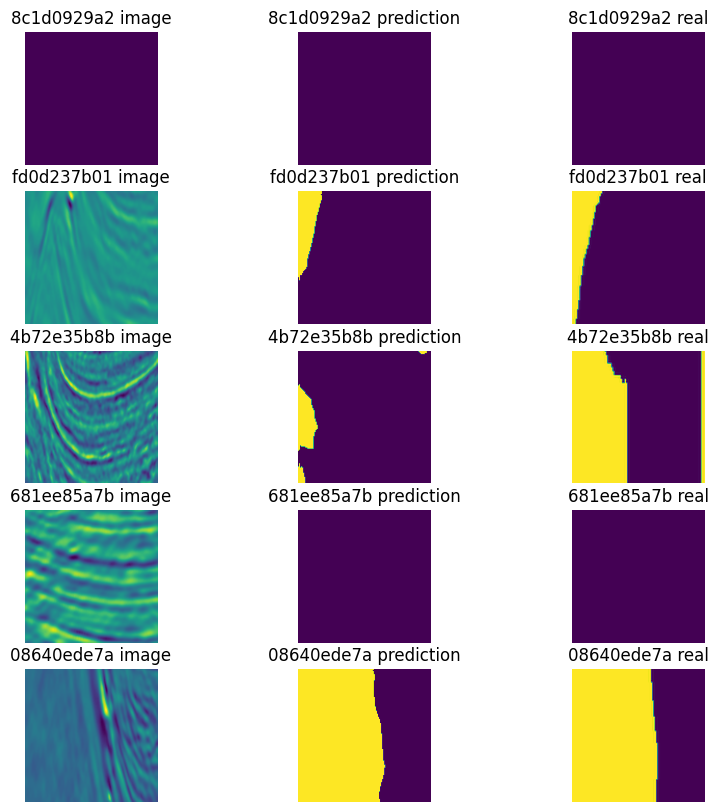

In [165]:
from random import sample
# load from model2.pth
model = UNet2().to('cuda')
model.load_state_dict(torch.load('model2.pth'))

ids = np.array(sample(list(dataset_ids), 5))

predictions = predict(model, ids)

plot_predictions(ids, predictions)


### 5.2 Skip Connections

The skip connections have been used in the proposed architecture. Why is this important ? Suppose that we remove these skip connections from the proposed architecture, how does it impact the result ? Please explain your intuition. Furthermore, the current skip connections consist of concatenating feature maps of the encoder with those of the decoder at the same level, is it possible to make use of other alternatives, for instance addition, Max or Min operation
? Do they impact the results ? Explain.



In [172]:
class UNetAddition(nn.Module):
    def __init__(self, debug=False):
        super(UNetAddition, self).__init__()
        self.debug = debug

        self.encoder_path()

        self.decoder_path()

    def encoder_path(self):
        self.c1 = self.double_conv_layer(1, 16)
        self.p1 = nn.MaxPool2d(2, 2)
        self.c2 = self.double_conv_layer(16, 32)
        self.p2 = nn.MaxPool2d(2, 2)
        self.c3 = self.double_conv_layer(32, 64)
        self.p3 = nn.MaxPool2d(2, 2)
        self.c4 = self.double_conv_layer(64, 128)
        self.p4 = nn.MaxPool2d(2, 2)
        self.c5 = self.double_conv_layer(128, 256)

    def decoder_path(self):
        self.u6 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.c6 = self.double_conv_layer(128, 128)
        self.u7 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.c7 = self.double_conv_layer(64, 64)
        self.u8 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.c8 = self.double_conv_layer(32, 32)
        self.u9 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.c9 = self.double_conv_layer(16, 16)
        self.output = nn.Sequential(
            nn.Conv2d(16, 1, 1),
            nn.Sigmoid()
        )



    def double_conv_layer(self, in_channels, out_channels, stride1=1, stride2=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=stride2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        c1 = self.c1(x)
        p1 = self.p1(c1)
        c2 = self.c2(p1)
        p2 = self.p2(c2)
        c3 = self.c3(p2)
        p3 = self.p3(c3)
        c4 = self.c4(p3)
        p4 = self.p4(c4)
        c5 = self.c5(p4)

        u6 = self.u6(c5)
        u6 = u6 + c4
        c6 = self.c6(u6)
        u7 = self.u7(c6)
        u7 = u7 + c3
        c7 = self.c7(u7)
        u8 = self.u8(c7)
        u8 = u8 + c2
        c8 = self.c8(u8)
        u9 = self.u9(c8)
        u9 = u9 + c1
        c9 = self.c9(u9)
        output = self.output(c9)

        return output


In [173]:
model = UNetAddition().to('cuda')

train(model, train_data, val_data, model_path='model_addition.pth')

Epoch 1
Epoch 1 Training Loss: 0.578809246122837
Epoch 1 Validation Loss: 0.5030695259571075
Epoch 2
Epoch 2 Training Loss: 0.47220470458269126
Epoch 2 Validation Loss: 0.4482282447814942
Epoch 3
Epoch 3 Training Loss: 0.4362047964334486
Epoch 3 Validation Loss: 0.42093721985816945
Epoch 4
Epoch 4 Training Loss: 0.4056621536612511
Epoch 4 Validation Loss: 0.39686284780502323
Epoch 5
Epoch 5 Training Loss: 0.38030011296272287
Epoch 5 Validation Loss: 0.37695506215095526
Epoch 6
Epoch 6 Training Loss: 0.3567682999372481
Epoch 6 Validation Loss: 0.35028895258903514
Epoch 7
Epoch 7 Training Loss: 0.3372396877408028
Epoch 7 Validation Loss: 0.33474294781684877
Epoch 8
Epoch 8 Training Loss: 0.3179037836194039
Epoch 8 Validation Loss: 0.31838377833366394
Epoch 9
Epoch 9 Training Loss: 0.29787341341376306
Epoch 9 Validation Loss: 0.30123233437538144
Epoch 10
Epoch 10 Training Loss: 0.28383172839879983
Epoch 10 Validation Loss: 0.28909819662570957
Epoch 11
Epoch 11 Training Loss: 0.26245777115

### 5.3 FCN and Auto-encoder
The proposed architecture is an auto-encoder like architecture, i.e., composed of an encoder and a decoder. Is it  necessary ? Is it possible that we make use of a fully convolutional neural network (FCN) consisting of series of convolutions from the input to the output while keeping the image size, i.e., width and height, during all the convolutions ?

Les encodeurs-décodeurs sont une structure optimisé pour la localisation spatiale des features dans des images, par rapport à la nature généraliste des FCN.

### 5.4 Threshold for inference
We have taken 0.5 as the threshold to decide whether to classify a pixel as salt or not. However, this choice proves not to be the optimal in terms of precision and recall rate for pixels being classified salt. Could you explain how we should define the precision and recall rate in our business case. Could you propose a strategy to improve both precision and recall ?

Here in this business case, we want as few false positives as possible, as they would lead to unnecessary drilling costs. So we should aim for a high precision rate. However, we also want to avoid false negatives, as they would lead to missing out on potential drilling sites. So we should also aim for a high recall rate.
We can use the F1 score to balance these two metrics: we could use a threshold that maximizes the F1 score, which is the harmonic mean of precision and recall.

In [ ]:
class UNetBase(nn.Module):
    def __init__(self, debug=False):
        super(UNetBase, self).__init__()
        self.debug = debug

        self.encoder_path()

        self.decoder_path()

    def encoder_path(self):
        self.c1 = self.double_conv_layer(1, 16)
        self.p1 = nn.MaxPool2d(2, 2)
        self.c2 = self.double_conv_layer(16, 32)
        self.p2 = nn.MaxPool2d(2, 2)
        self.c3 = self.double_conv_layer(32, 64)
        self.p3 = nn.MaxPool2d(2, 2)
        self.c4 = self.double_conv_layer(64, 128)
        self.p4 = nn.MaxPool2d(2, 2)
        self.c5 = self.double_conv_layer(128, 256)

    def decoder_path(self):
        self.u6 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.c6 = self.double_conv_layer(256, 128)
        self.u7 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.c7 = self.double_conv_layer(128, 64)
        self.u8 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.c8 = self.double_conv_layer(64, 32)
        self.u9 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.c9 = self.double_conv_layer(32, 16)
        self.output = nn.Sequential(
            nn.Conv2d(16, 1, 1),
            nn.Sigmoid()
        )



    def double_conv_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        c1 = self.c1(x)
        p1 = self.p1(c1)
        c2 = self.c2(p1)
        p2 = self.p2(c2)
        c3 = self.c3(p2)
        p3 = self.p3(c3)
        c4 = self.c4(p3)
        p4 = self.p4(c4)
        c5 = self.c5(p4)

        u6 = self.u6(c5)
        u6 = torch.cat([u6, c4], 1)
        c6 = self.c6(u6)
        u7 = self.u7(c6)
        u7 = torch.cat([u7, c3], 1)
        c7 = self.c7(u7)
        u8 = self.u8(c7)
        u8 = torch.cat([u8, c2], 1)
        c8 = self.c8(u8)
        u9 = self.u9(c8)
        u9 = torch.cat([u9, c1], 1)
        c9 = self.c9(u9)
        output = self.output(c9)

        return output
